# Structural plasticity

Download the Jupyter notebook : [StructuralPlasticity.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/StructuralPlasticity.ipynb)

As simple example showing how to use structural plasticity (creation/pruning of synapses) in a rate-coded network (spiking networks work similarly).

First, the structural plasticity mechanisms must be allowed in `setup()`:

In [1]:
from ANNarchy import *
clear()

# Compulsory to allow structural plasticity
setup(structural_plasticity=True)

ANNarchy 4.7 (4.7.3) on darwin (posix).


We define a leaky integrator rate-coded neuron and a small population: 

In [2]:
LeakyIntegratorNeuron = Neuron(
    parameters="""
        tau = 10.0 : population
        baseline = 0.0 
    """,
    equations = """
        tau * dr/dt + r = baseline + sum(exc) : min=0.0
    """
)
pop = Population(100, LeakyIntegratorNeuron)

Structural plasticity has two components: creation of synapses and pruning (removal) under certain conditions. These conditions are defined in the synapse type itself in the `pruning` and `creating` arguments: 

In [3]:
StructuralPlasticSynapse = Synapse(
    parameters = " T = 10000 : int, projection ",
    equations = """
        age = if pre.r * post.r > 1.0 :
                0
              else :
                age + 1 : init = 0, int""",
    pruning = "age > T : proba = 0.2",
    creating = "pre.r * post.r > 1.0 : proba = 0.1, w = 0.01",
)

proj = Projection(pop, pop, 'exc', StructuralPlasticSynapse)
proj.connect_fixed_probability(weights = 0.01, probability=0.1)

These conditions must be boolean values, which when `True` may trigger the creation/pruning of a synapse. The flag `proba` gives the probability by which the synapse will actually be created/pruned.

* When `creating` is `True`, a synapse that did not exist will be created with the provided probability. Its weight will take the value provided by the flag `w` (0.01), the other variables take their default value.
* When `pruning` is `True`, a synapse that exists will be deleted with the given probability.

The `pruning` condition can depend on any pre-synaptic, post-synaptic or synaptic variable. The `creating` condition can only depend on pre- or post-synaptic conditions, as the synapse does not exist yet.

Apart from these two fields, the synapse is a regular synapse, one could also define synaptic plasticity mechanisms and so on.

We finally create a sparse projection within the population, with 10% connectivity.

In [4]:
compile()

Compiling ...  OK 


The creation and pruning have to be explicitly started before a simulation, as they are very expensive computationally. The `period` argument states how often the conditions will be checked (avoid using `dt`):

In [5]:
proj.start_creating(period=100.0)
proj.start_pruning(period=100.0)

To see the effect of structural plasticity, one alternatively activates one half of the population by setting a high baseline (mimicking corrrelated inputs). As neurons in one half will be activated at the same time, they will create synapses between each other. Between the two halves, the neurons are never co-activated, so the existing synapses will slowly die out.  

In [6]:
# Save the initial connectivity matrix
initial_weights = proj.connectivity_matrix()

# Let structural plasticity over several trials
num_trials = 100
for trial in range(num_trials):
    # Activate the first subpopulation
    pop[:50].baseline = 1.0
    # Simulate for 1s
    simulate(1000.)
    # Reset the population
    pop.baseline = 0.0
    simulate(100.)
    # Activate the second subpopulation
    pop[50:].baseline = 1.0
    # Simulate for 1s
    simulate(1000.)
    # Reset the population
    pop.baseline = 0.0
    simulate(100.)

# Inspect the final connectivity matrix
final_weights = proj.connectivity_matrix()

We can check the effect of structural plasticity by looking at the connectivity matrix before and after the stimulation:

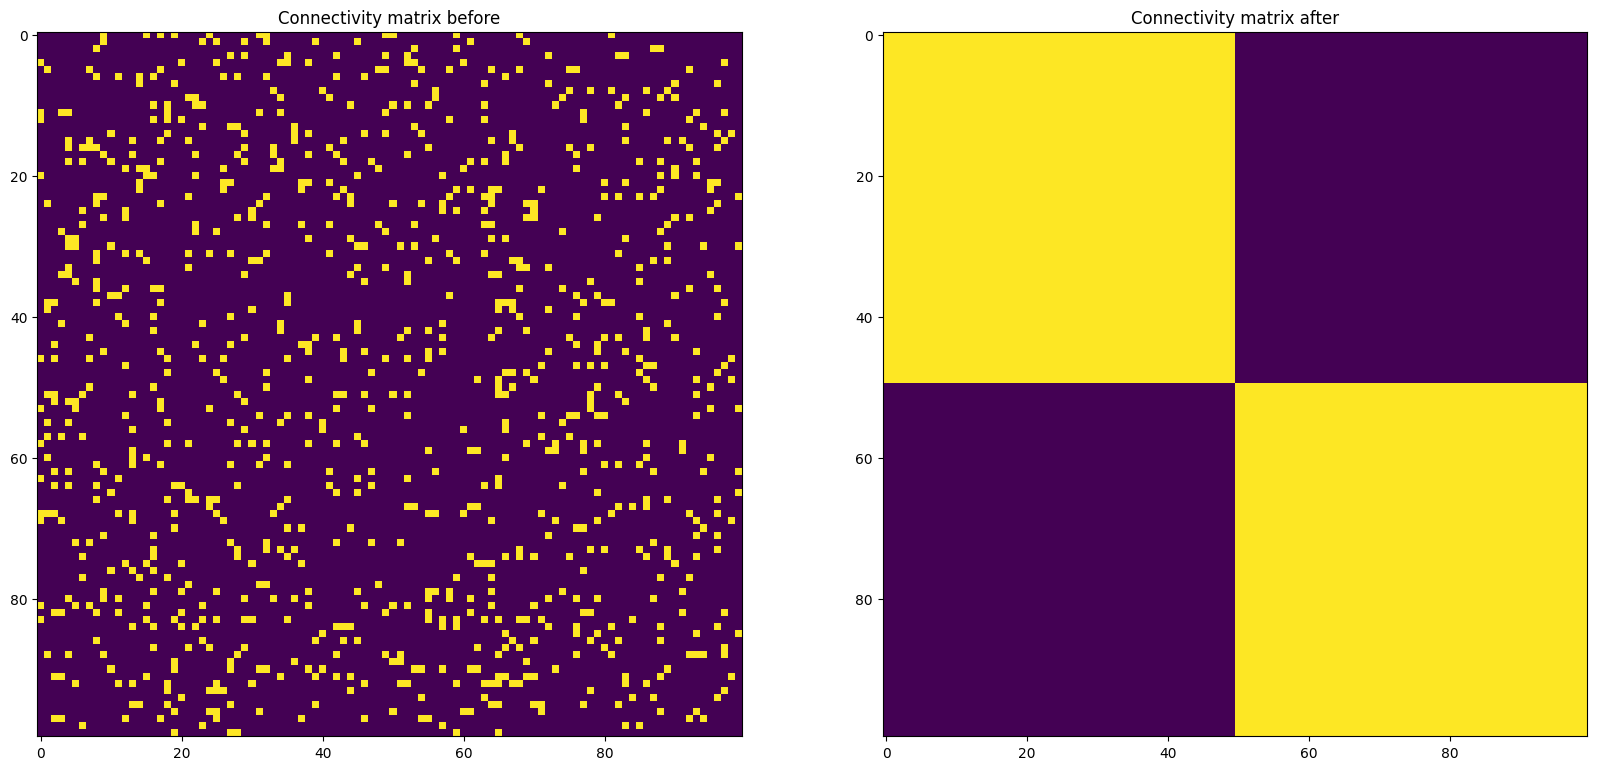

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
plt.subplot(121)
plt.imshow(initial_weights)
plt.title('Connectivity matrix before')
plt.subplot(122)
plt.imshow(final_weights)
plt.title('Connectivity matrix after')
plt.show()